# CT processing for the new and improved data pipeline 

Steps involved:
1. Smoothing to remove/minimize overshoots, if any
2. Data augmentation transform
3. Intensity normalization -- 2 options: Clipping + Min-max rescaling OR Histogram standardization

In [1]:
import os, time

import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import SimpleITK as sitk
import torchio
from torchio.transforms import HistogramStandardization

import sys
sys.path.append('../')
from datautils.visualization import NdimageVisualizer, display_image
from datautils.conversion import *

If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Credits instructions: https://torchio.readthedocs.io/#credits



In [2]:
# Settings 
data_dir = "/home/chinmay/Datasets/HECKTOR/hecktor_train/crFHN_rs113_hecktor_nii"
normalization_method = 'clip-and-rescale'  # 'clip-and-rescale' or 'histogram-mapping

## Comparing the difference in HU range between 2 CT volumes 

Min and Max HU: -3641.4973 2005.5107


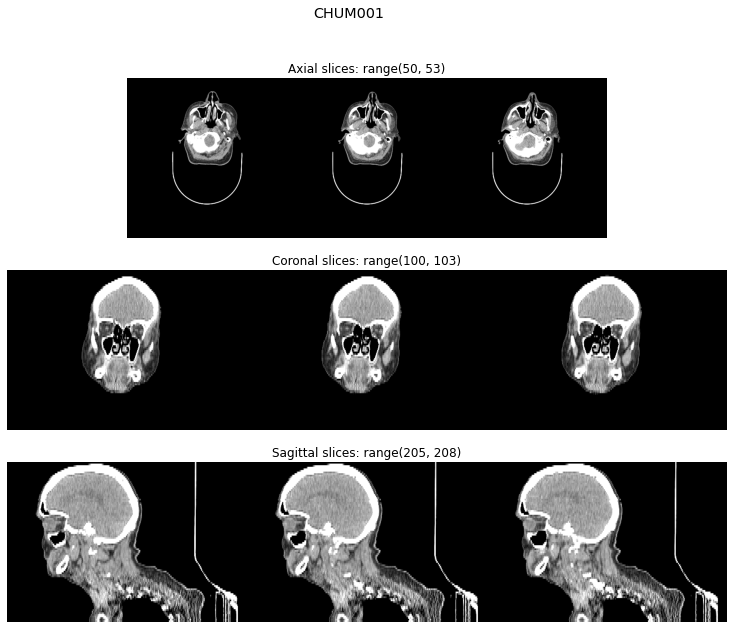

In [3]:
patient_1 = "CHUM001"
CT_sitk = sitk.ReadImage(f"{data_dir}/{patient_1}_ct.nii.gz") # Shape (W,H,D): 450x450x90 voxels
CT_np = sitk2np(CT_sitk, keep_whd_ordering=True)

print("Min and Max HU:", CT_np.min(), CT_np.max())

display_image(CT_sitk,
               axial_idxs=range(50,53),
               coronal_idxs=range(100,103),
               sagittal_idxs=range(205,208),
               window={'level':0, 'width':300},
               title=patient_1, cmap='gray')

Min and Max HU: -16757.941 30057.14


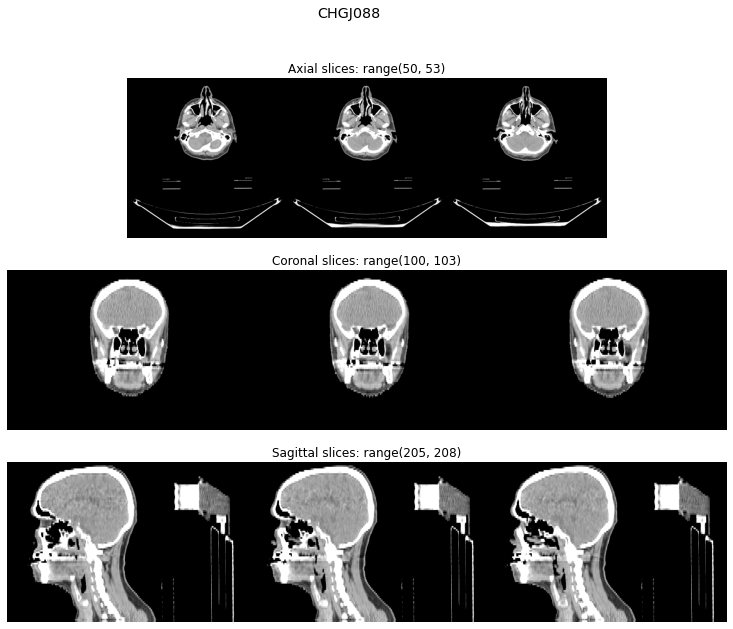

In [4]:
patient_2 = "CHGJ088"
CT2_sitk = sitk.ReadImage(f"{data_dir}/{patient_2}_ct.nii.gz") # Shape (W,H,D): 450x450x90 voxels
CT2_np = sitk2np(CT2_sitk, keep_whd_ordering=True)

print("Min and Max HU:", CT2_np.min(), CT2_np.max())

display_image(CT2_sitk,
               axial_idxs=range(50,53),
               coronal_idxs=range(100,103),
               sagittal_idxs=range(205,208),
               window={'level':0, 'width':300},
               title=patient_2, cmap='gray')

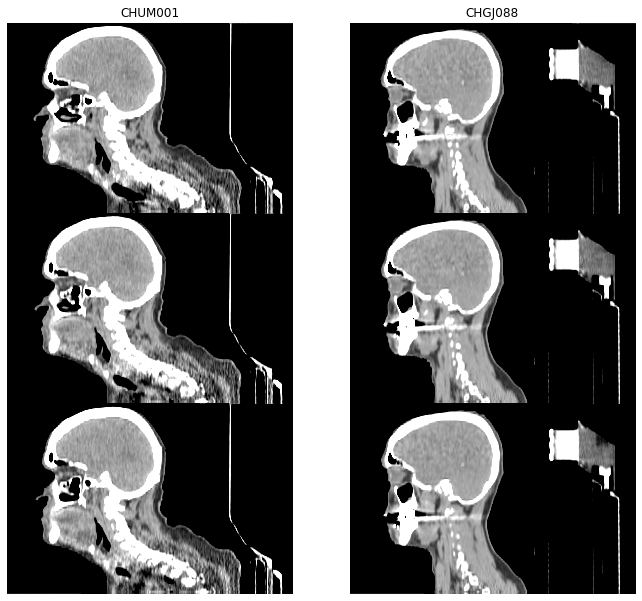

In [5]:
viz = NdimageVisualizer()
viz.multi_image_strips([CT_np, CT2_np],
                          modalities=['CT'] * 2,
                          idx_range=[250, 253],
                          view='sagittal',
                          subtitles=[patient_1, patient_2])

## 1 Smoothing

In [6]:
t1 = time.time()
sigma = [1.0, 1.0, 1.0/3] # In format (W,H,D), Physical sigma of 2mm adjusted according to voxel spacing
CT_smooth_np = scipy.ndimage.gaussian_filter(CT_np, sigma=sigma)
time_diff = time.time() - t1

#print(f"Time taken for filtering: {time_diff:.2f}s")

print("Min and Max HU:", CT_smooth_np.min(), CT_smooth_np.max())

Min and Max HU: -3024.0251 1827.3124


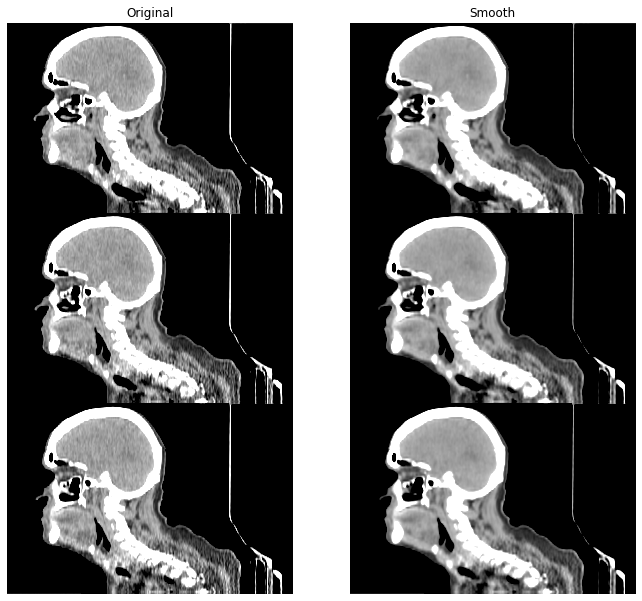

In [7]:
# Display
viz.multi_image_strips([CT_np, CT_smooth_np],
                          modalities=['CT'] * 2,
                          idx_range=[250, 253],
                          view='sagittal',
                          subtitles=["Original", "Smooth"])

## 3 Data Augmentation

### 3.2 Random rotation

In [9]:
# Affine matrix that encodes the spacing (1,1,3) as 3x scaling/zoom along z-axis
affine_matrix = np.array([[1,0,0,0],
                          [0,1,0,0],
                          [0,0,3,0],
                          [0,0,0,1]])

CT_tio = torchio.Image(tensor=np.expand_dims(CT_smooth_np,axis=0), type=torchio.INTENSITY, affine=affine_matrix)
print("Spacing:", CT_tio.spacing) # Check the spacing

subject = torchio.Subject({'CT':CT_tio})

Spacing: (1.0, 1.0, 3.0)


In [10]:
rotation_transform = torchio.RandomAffine(scales=(1,1), degrees=(-10,10), translation=(0,0))
CT_rot_np = rotation_transform(subject).get_images_dict()['CT'].numpy().squeeze()

### 3.3 Random scaling (no change in image size)

In [11]:
scaling_transform = torchio.RandomAffine(scales=(0.85,1.15), degrees=(0,0), translation=(0,0))
CT_scl_np = scaling_transform(subject).get_images_dict()['CT'].numpy().squeeze()

### 3.4 Elastic distortion

In [12]:
elastic_transform = torchio.RandomElasticDeformation(num_control_points=(7,7,7), max_displacement=(20,20,20), locked_borders=2)
CT_elastic_np = elastic_transform(subject).get_images_dict()['CT'].numpy().squeeze()

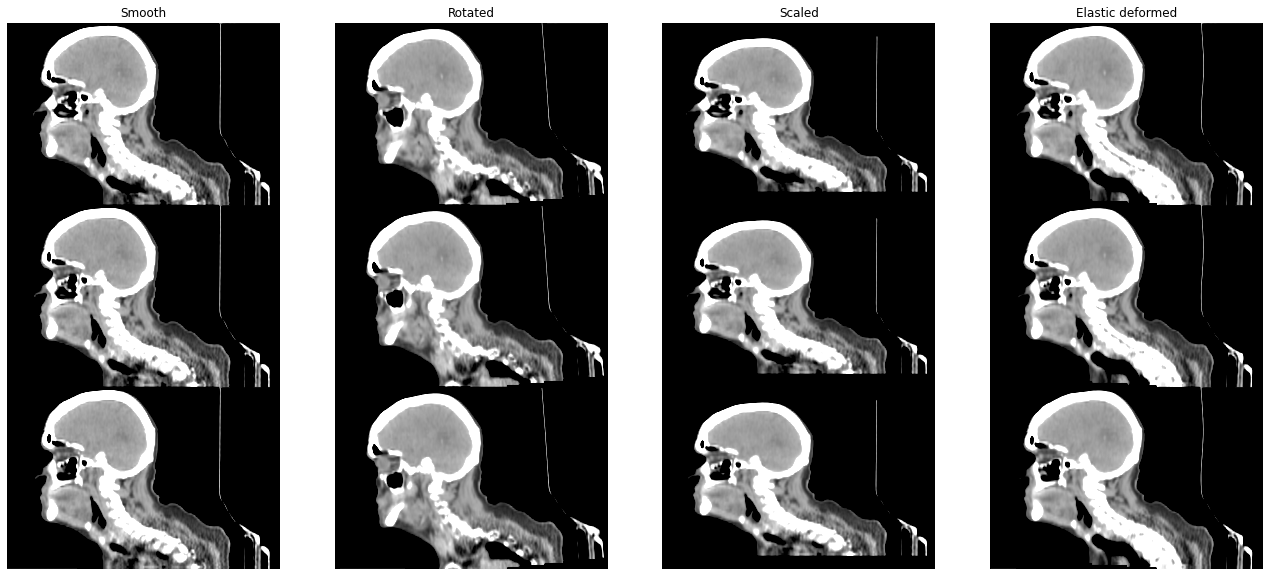

In [13]:
# Displays
viz.multi_image_strips([CT_smooth_np, CT_rot_np, CT_scl_np, CT_elastic_np],
                          modalities=['CT'] * 4,
                          idx_range=[250, 253],
                          view='sagittal',
                          subtitles=["Smooth", "Rotated", "Scaled", "Elastic deformed"])

## 3 Intensity Normalization

In [15]:
if normalization_method == 'clip-and-rescale':
    clipping_range = [-150,150] # HU
    CT_norm_np = np.clip(CT_smooth_np, clipping_range[0], clipping_range[1])
    CT_norm_np = (CT_norm_np - CT_norm_np.min()) / (CT_norm_np.max() - CT_norm_np.min())

elif normalization_method == 'histogram-mapping':
    # TODO
    pass


print("Min and Max HU:", CT_norm_np.min(), CT_norm_np.max())

Min and Max HU: 0.0 1.0
